In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows',0)
pd.set_option('display.max_columns',0)

In [2]:
df = pd.read_csv('dataset/cardio_train.csv', sep=';')
print(df.shape)

(69301, 13)


## Data Description

In [3]:
df.head()

id    age  gender  height  weight  ...  gluc  smoke  alco  active  cardio
0  988  22469       1     155    69.0  ...     2      0     0       1       0
1  989  14648       1     163    71.0  ...     1      0     0       1       1
2  990  21901       1     165    70.0  ...     1      0     0       1       0
3  991  14549       2     165    85.0  ...     1      1     1       1       0
4  992  23393       1     155    62.0  ...     1      0     0       1       0

[5 rows x 13 columns]

In [4]:
df.tail()

id    age  gender  height  weight  ...  gluc  smoke  alco  active  cardio
69296  99993  19240       2     168    76.0  ...     1      1     0       1       0
69297  99995  22601       1     158   126.0  ...     2      0     0       1       1
69298  99996  19066       2     183   105.0  ...     1      0     1       0       1
69299  99998  22431       1     163    72.0  ...     2      0     0       0       1
69300  99999  20540       1     170    72.0  ...     1      0     0       1       0

[5 rows x 13 columns]

Features:
1. Age | Objective Feature | age | int (days) | (numeric feature)
2. Height | Objective Feature | height | int (cm) | (numeric feature)
3. Weight | Objective Feature | weight | float (kg) | (numeric feature)
4. Gender | Objective Feature | gender | categorical code | (categorical feautures)
5. Systolic blood pressure | Examination Feature | ap_hi | int | (numeric feature)
6. Diastolic blood pressure | Examination Feature | ap_lo | int | (numeric feature)
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal | (categorical feautures)
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal | (categorical feautures)
9. Smoking | Subjective Feature | smoke | binary | (categorical feautures)
10. Alcohol intake | Subjective Feature | alco | binary | (categorical feautures)
11. Physical activity | Subjective Feature | active | binary | (categorical feautures)
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary | (categorical feautures)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           69301 non-null  int64  
 1   age          69301 non-null  int64  
 2   gender       69301 non-null  int64  
 3   height       69301 non-null  int64  
 4   weight       69301 non-null  float64
 5   ap_hi        69301 non-null  int64  
 6   ap_lo        69301 non-null  int64  
 7   cholesterol  69301 non-null  int64  
 8   gluc         69301 non-null  int64  
 9   smoke        69301 non-null  int64  
 10  alco         69301 non-null  int64  
 11  active       69301 non-null  int64  
 12  cardio       69301 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
df.describe().T

count          mean           std  ...      50%      75%      max
id           69301.0  50471.480397  28563.100347  ...  50494.0  75150.0  99999.0
age          69301.0  19468.786280   2467.261818  ...  19704.0  21326.0  23713.0
gender       69301.0      1.349519      0.476821  ...      1.0      2.0      2.0
height       69301.0    164.362217      8.205337  ...    165.0    170.0    250.0
weight       69301.0     74.203027     14.383469  ...     72.0     82.0    200.0
ap_hi        69301.0    128.829584    154.775805  ...    120.0    140.0  16020.0
ap_lo        69301.0     96.650092    189.096240  ...     80.0     90.0  11000.0
cholesterol  69301.0      1.366806      0.680270  ...      1.0      2.0      3.0
gluc         69301.0      1.226447      0.572246  ...      1.0      1.0      3.0
smoke        69301.0      0.088051      0.283371  ...      0.0      0.0      1.0
alco         69301.0      0.053881      0.225784  ...      0.0      0.0      1.0
active       69301.0      0.803986      0.396982  ...      1.0      1.0      1.0
cardio       69301.0      0.499589      0.500003  ...      0.0      1.0      1.0

[13 rows x 8 columns]

Let's change the column names to be a bit clearer

In [7]:
df.drop('id',1,inplace=True)

df.columns = ['age','gender','height','weight','systolic_blood_pressure','diastolic_blood_pressure',
              'cholesterol','glucose_level','smoking','alcohol_intake','physical_activity','target']

I'm also going to change the values of the categorical variables, to improve the interpretation later on,

In [8]:
df.head()

age  gender  height  ...  alcohol_intake  physical_activity  target
0  22469       1     155  ...               0                  1       0
1  14648       1     163  ...               0                  1       1
2  21901       1     165  ...               0                  1       0
3  14549       2     165  ...               1                  1       0
4  23393       1     155  ...               0                  1       0

[5 rows x 12 columns]

In [9]:
df['age'] = np.round(df['age'] / 365)

df['gender'][df['gender']==1] = 'male'
df['gender'][df['gender']==2] = 'female'

df['cholesterol'][df['cholesterol']==1] = 'normal'
df['cholesterol'][df['cholesterol']==2] = 'above normal'
df['cholesterol'][df['cholesterol']==3] = 'well above normal'

df['glucose_level'][df['glucose_level']==1] = 'normal'
df['glucose_level'][df['glucose_level']==2] = 'above normal'
df['glucose_level'][df['glucose_level']==3] = 'well above normal'

df['smoking'][df['smoking']==0] = 'no'
df['smoking'][df['smoking']==1] = 'yes'

df['alcohol_intake'][df['alcohol_intake']==0] = 'no'
df['alcohol_intake'][df['alcohol_intake']==1] = 'yes'

df['physical_activity'][df['physical_activity']==0] = 'no'
df['physical_activity'][df['physical_activity']==1] = 'yes'

In [10]:
df.head()

age  gender  height  ...  alcohol_intake  physical_activity  target
0  62.0    male     155  ...              no                yes       0
1  40.0    male     163  ...              no                yes       1
2  60.0    male     165  ...              no                yes       0
3  40.0  female     165  ...             yes                yes       0
4  64.0    male     155  ...              no                yes       0

[5 rows x 12 columns]

In [11]:
df.to_csv('cleaned_data.csv', index=False)

df = pd.read_csv('cleaned_data.csv')
df.head()

age  gender  height  ...  alcohol_intake  physical_activity  target
0  62.0    male     155  ...              no                yes       0
1  40.0    male     163  ...              no                yes       1
2  60.0    male     165  ...              no                yes       0
3  40.0  female     165  ...             yes                yes       0
4  64.0    male     155  ...              no                yes       0

[5 rows x 12 columns]

## Data exploration

**Value counts**

In [12]:
print("Percentage of patients not having Cardiovascular Disease: {:.2f}%".format((df['target'].value_counts()[0]/len(df))*100))
print("Percentage of patients having Cardiovascular Disease: {:.2f}%".format((df['target'].value_counts()[1]/len(df))*100))

Percentage of patients not having Cardiovascular Disease: 50.04%
Percentage of patients having Cardiovascular Disease: 49.96%


#### cardio

The target variable

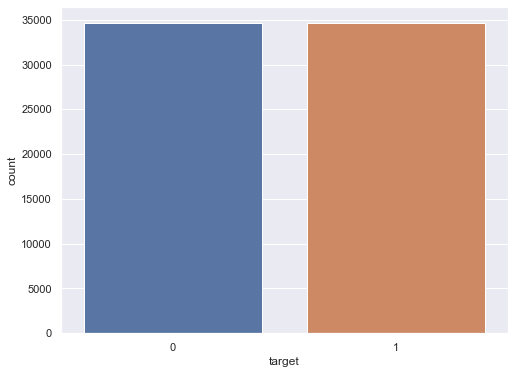

In [13]:
sns.set(style="darkgrid")
plt.figure(figsize=(8,6))
ax = sns.countplot(x="target", data=df)

We can see the data is almost evenly distributed among the two targets with 50.04% belonging to class 0 and 49.96% to class 1. Therefore our model will not be much biased in predicting the classes.

#### age

In [14]:
df['age'].min(), df['age'].max()

(30.0, 65.0)

The ages of the patient in our dataset ranges from 30 to 65

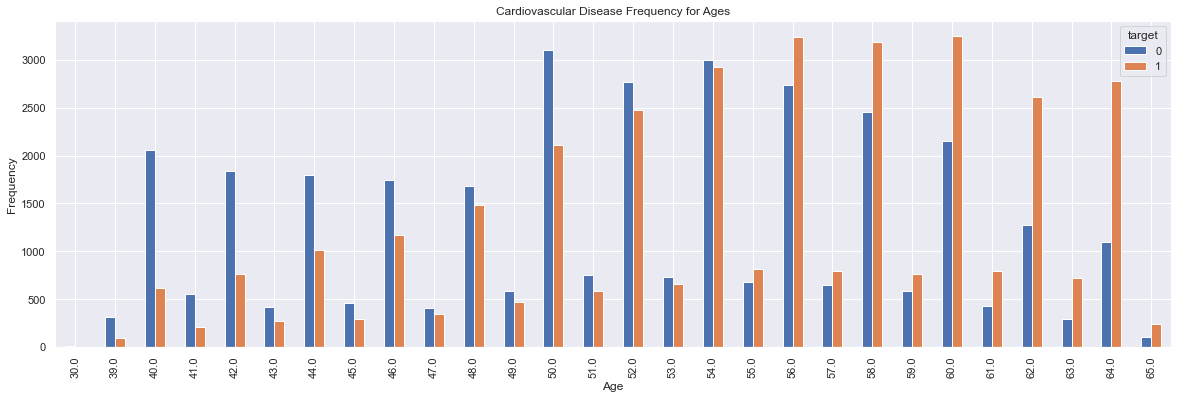

In [15]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Cardiovascular Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

From the graph it is clear that older people are more likely to have cardiovascular diseases.

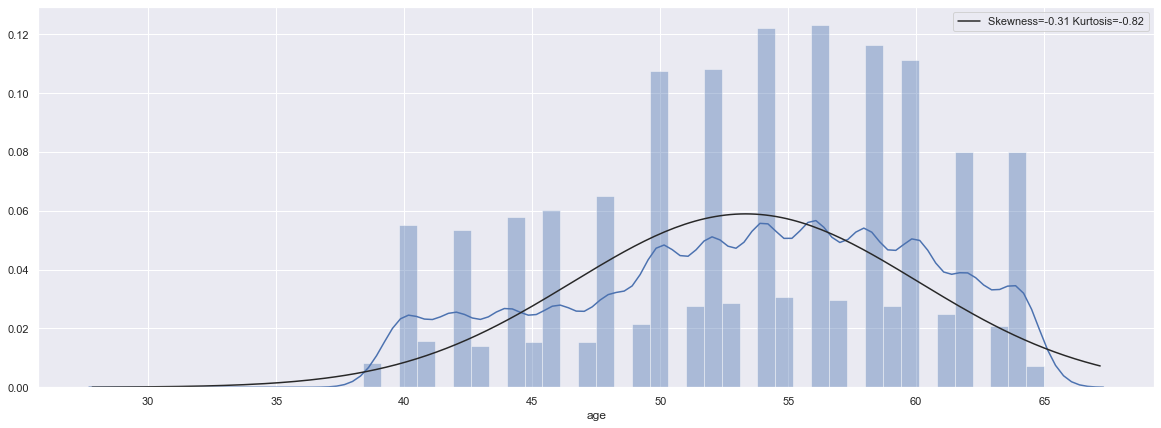

In [16]:
f,ax = plt.subplots(figsize = (20,7))
sns.set_style("darkgrid")
sns.distplot(df.age, fit=norm);
plt.legend(['Skewness={:.2f} Kurtosis={:.2f}'.format(
            df['age'].skew(), 
            df['age'].kurt())
        ],
        loc='best')

We expect that our data points will be on red line for gaussian distributin. We see dist tails


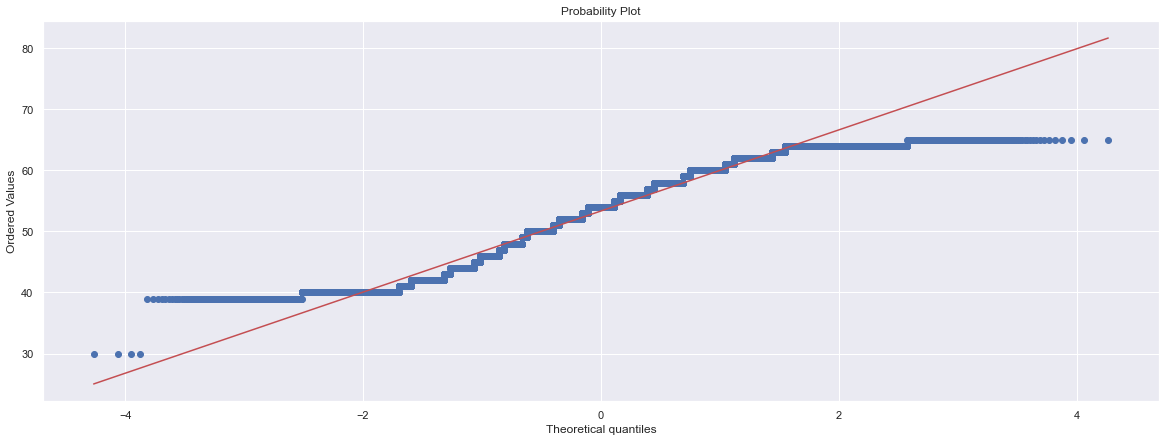

In [17]:
# qq plot:
plt.figure(figsize = (20,7))
stats.probplot(df["age"],plot=plt)
plt.show
print("We expect that our data points will be on red line for gaussian distributin. We see dist tails")

The age data is not normally distributed. We need to normalize it for fitting our model.

#### gender

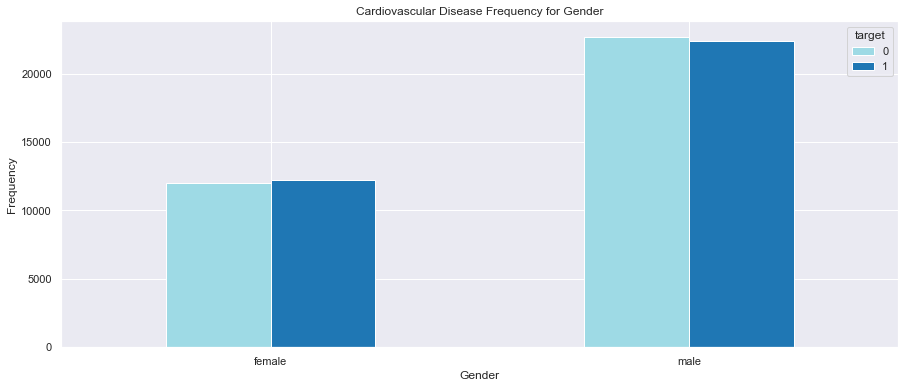

In [18]:
pd.crosstab(df.gender,df.target).plot(kind="bar",colormap="tab20_r",figsize=(15,6))
plt.title('Cardiovascular Disease Frequency for Gender')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

In [19]:
perc_female_target = df[df['gender']=='female']['target'].sum() / len(df[df['gender']=='female']) * 100
perc_male_target = df[df['gender']=='male']['target'].sum() / len(df[df['gender']=='male']) * 100

print(f'Percentage of female patients having cardionvascular disease {np.round(perc_female_target,2)}%')
print(f'Percentage of male patients having cardionvascular disease {np.round(perc_male_target,2)}%')

Percentage of female patients having cardionvascular disease 50.54%
Percentage of male patients having cardionvascular disease 49.64%


In our dataset, the patients irrespective of the gender have equal number of affected and non-affected cases.

#### height

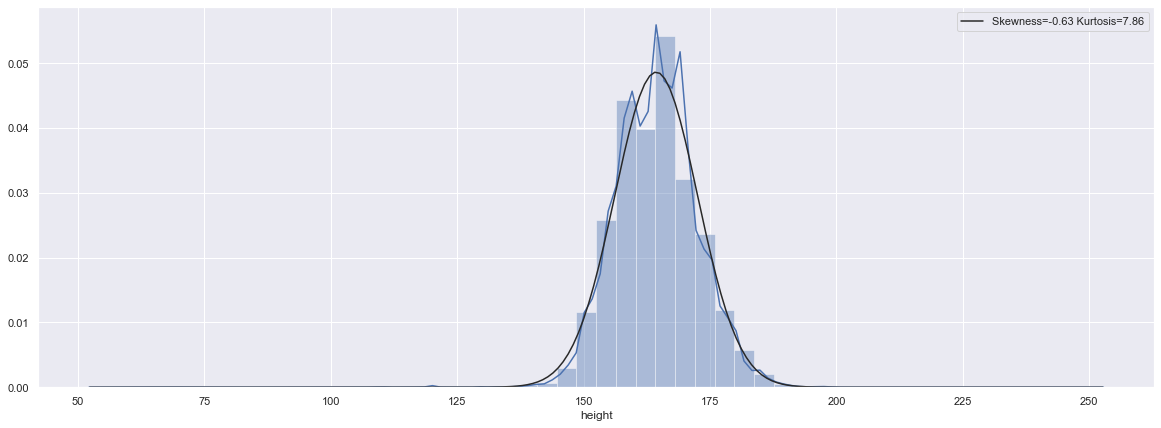

In [20]:
f,ax = plt.subplots(figsize = (20,7))
sns.set_style("darkgrid")
sns.distplot(df.height, fit=norm);
plt.legend(['Skewness={:.2f} Kurtosis={:.2f}'.format(
            df['height'].skew(), 
            df['height'].kurt())
        ],
        loc='best')

The heights data is normally distributed.

In [21]:
df.groupby('target')['height'].mean().reset_index()

target      height
0       0  164.452522
1       1  164.271764

It seems height doesn't play a major role in detecting the target

#### weights

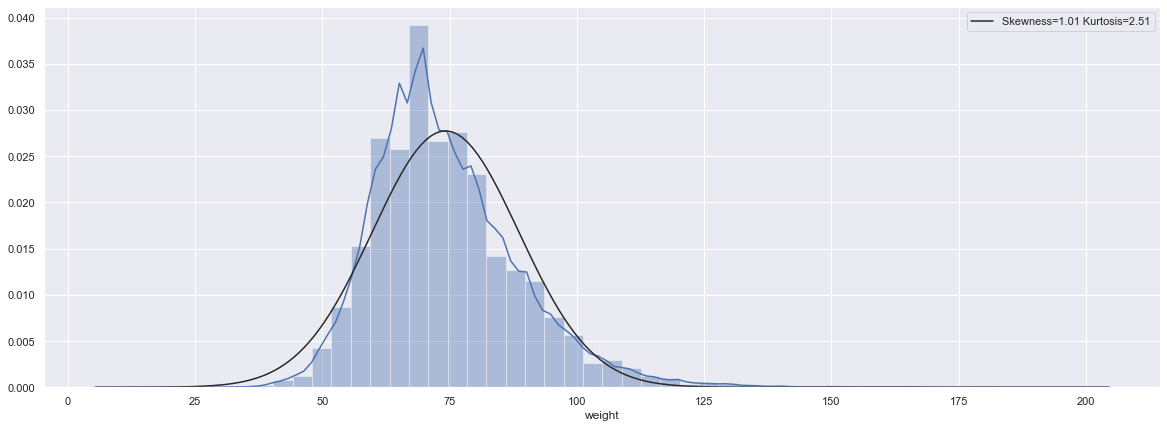

In [22]:
f,ax = plt.subplots(figsize = (20,7))
sns.set_style("darkgrid")
sns.distplot(df.weight, fit=norm);
plt.legend(['Skewness={:.2f} Kurtosis={:.2f}'.format(
            df['weight'].skew(), 
            df['weight'].kurt())
        ],
        loc='best')

The weight data is normally distributed.

In [23]:
df.groupby('target')['weight'].mean().reset_index()

target     weight
0       0  71.586058
1       1  76.824305

It seems patient with more weight has a tendency of having cardiovascular disease.

#### systolic_blood_pressure

In [24]:
df['systolic_blood_pressure'].min(), df['systolic_blood_pressure'].max()

(-150, 16020)

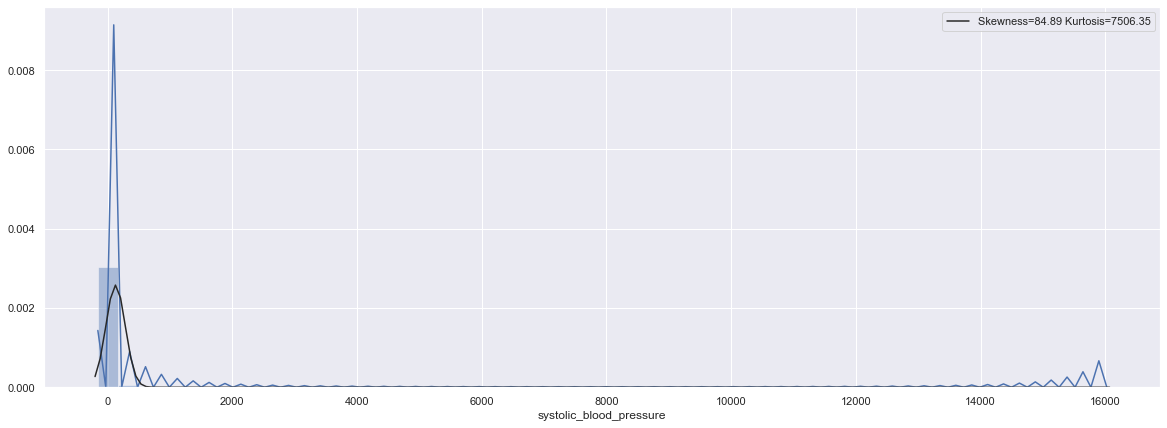

In [25]:
f,ax = plt.subplots(figsize = (20,7))
sns.set_style("darkgrid")
sns.distplot(df.systolic_blood_pressure, fit=norm);
plt.legend(['Skewness={:.2f} Kurtosis={:.2f}'.format(
            df['systolic_blood_pressure'].skew(), 
            df['systolic_blood_pressure'].kurt())
        ],
        loc='best')

In [26]:
df.groupby('target')['systolic_blood_pressure'].mean().reset_index()

target  systolic_blood_pressure
0       0               120.446034
1       1               137.226937

People with higher systolic blood pressure are prone to cardiovascular disease

#### diastolic_blood_pressure

In [27]:
df['diastolic_blood_pressure'].min(), df['diastolic_blood_pressure'].max()

(-70, 11000)

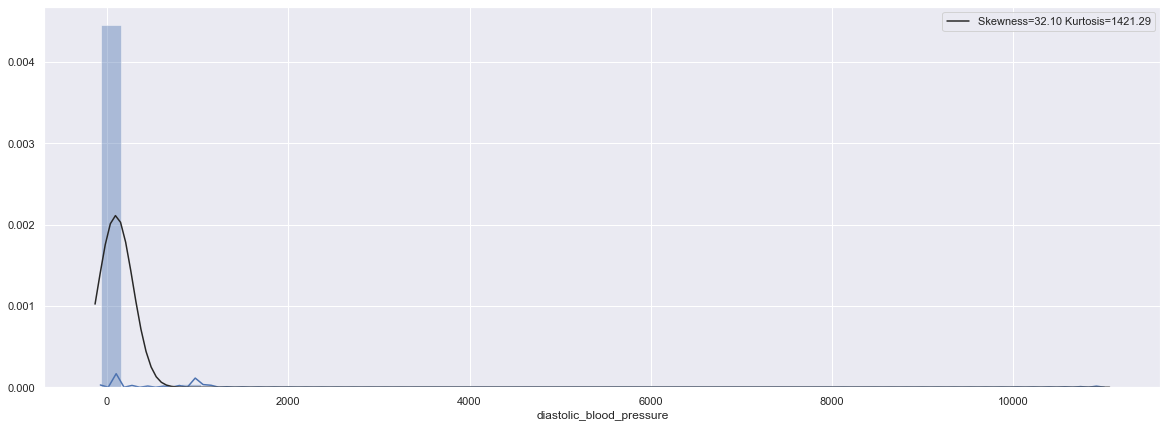

In [28]:
f,ax = plt.subplots(figsize = (20,7))
sns.set_style("darkgrid")
sns.distplot(df.diastolic_blood_pressure, fit=norm);
plt.legend(['Skewness={:.2f} Kurtosis={:.2f}'.format(
            df['diastolic_blood_pressure'].skew(), 
            df['diastolic_blood_pressure'].kurt())
        ],
        loc='best')

In [29]:
df.groupby('target')['diastolic_blood_pressure'].mean().reset_index()

target  diastolic_blood_pressure
0       0                 84.314225
1       1                109.006268

People with higher diastolic blood pressure are prone to cardiovascular disease

#### cholesterol

In [30]:
df.cholesterol.value_counts()

normal               51868
above normal          9446
well above normal     7987
Name: cholesterol, dtype: int64

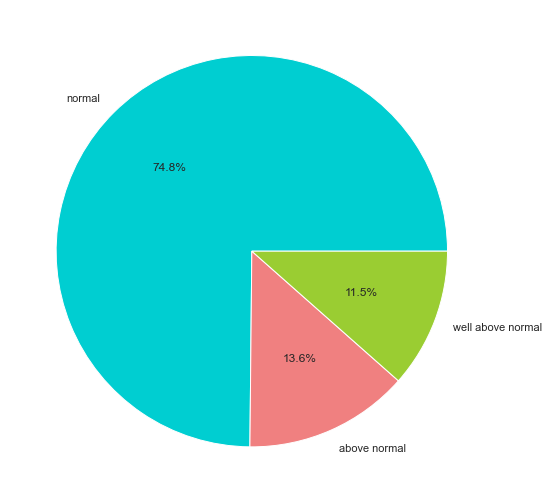

In [31]:
plt.figure(figsize = (20,9))
colors = ['darkturquoise','lightcoral','yellowgreen','deepskyblue']
plt.pie(x=df.cholesterol.value_counts(), 
        labels=df.cholesterol.value_counts().index,
        colors=colors,
        autopct='%1.1f%%');

In our dataset a major number of the patients have normal cholesterol level with 74%. Follwed by above normal level patients with 13.6% and well above normal with 11.5%

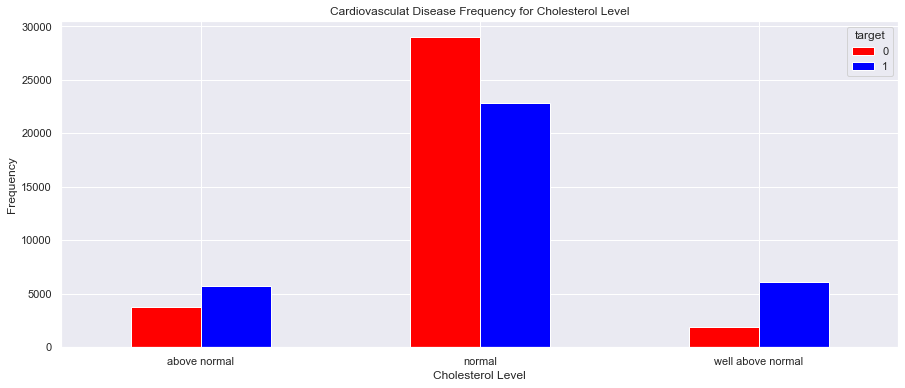

In [32]:
pd.crosstab(df.cholesterol,df.target).plot(kind="bar",colormap="bwr_r",figsize=(15,6))
plt.title('Cardiovasculat Disease Frequency for Cholesterol Level')
plt.xlabel('Cholesterol Level')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

Patients having cholesterol level above normal are prone to have cardiovascular diseases.

#### glucose_level

In [33]:
df.glucose_level.value_counts()

normal               58885
well above normal     5277
above normal          5139
Name: glucose_level, dtype: int64

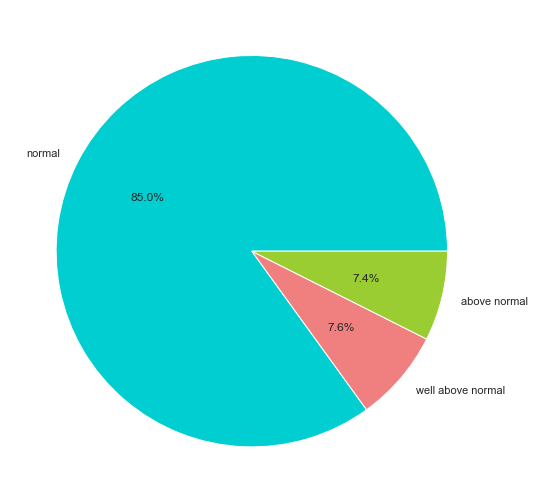

In [34]:
plt.figure(figsize = (20,9))
colors = ['darkturquoise','lightcoral','yellowgreen','deepskyblue']
plt.pie(x=df.glucose_level.value_counts(), 
        labels=df.glucose_level.value_counts().index,
        colors=colors,
        autopct='%1.1f%%');

In our dataset a major number of the patients have normal cholesterol level with 85%. Follwed by above normal level patients with 7.4% and well above normal with 7.6%

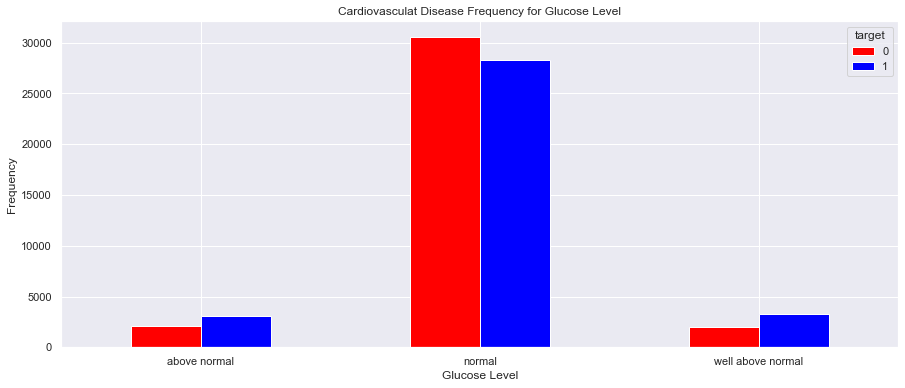

In [35]:
pd.crosstab(df.glucose_level,df.target).plot(kind="bar",colormap="bwr_r",figsize=(15,6))
plt.title('Cardiovasculat Disease Frequency for Glucose Level')
plt.xlabel('Glucose Level')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

Patients having glucose level above normal are prone to have cardiovascular diseases.

#### smoking

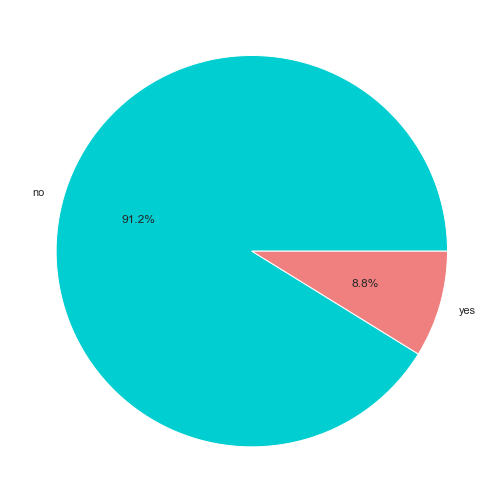

In [36]:
plt.figure(figsize = (20,9))
colors = ['darkturquoise','lightcoral','yellowgreen','deepskyblue']
plt.pie(x=df.smoking.value_counts(), 
        labels=df.smoking.value_counts().index,
        colors=colors,
        autopct='%1.1f%%');

About 92% of our dataset do not smoke.

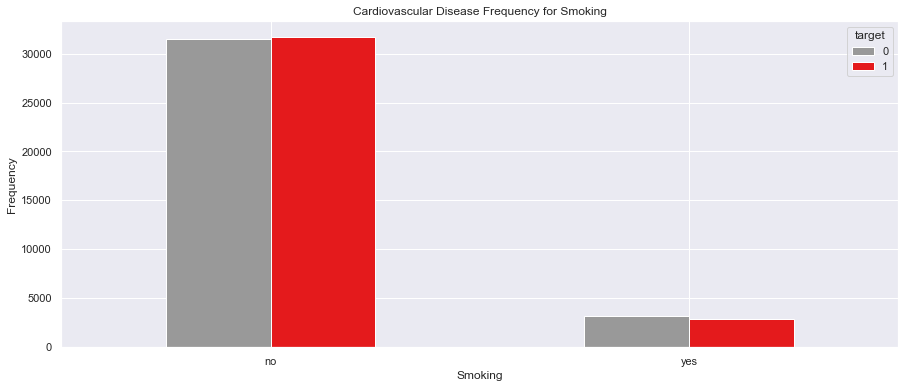

In [37]:
pd.crosstab(df.smoking,df.target).plot(kind="bar",colormap="Set1_r",figsize=(15,6))
plt.title('Cardiovascular Disease Frequency for Smoking')
plt.xlabel('Smoking')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

#### alcohol_intake

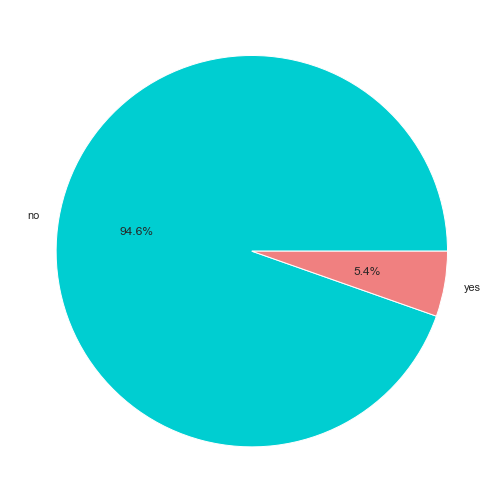

In [38]:
plt.figure(figsize = (20,9))
colors = ['darkturquoise','lightcoral','yellowgreen','deepskyblue']
plt.pie(x=df.alcohol_intake.value_counts(), 
        labels=df.alcohol_intake.value_counts().index,
        colors=colors,
        autopct='%1.1f%%');

About 94% of our dataset do not drink.

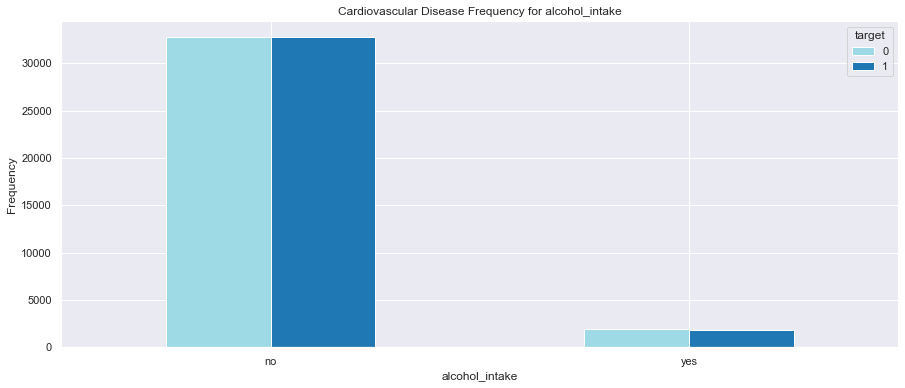

In [39]:
pd.crosstab(df.alcohol_intake,df.target).plot(kind="bar",colormap="tab20_r",figsize=(15,6))
plt.title('Cardiovascular Disease Frequency for alcohol_intake')
plt.xlabel('alcohol_intake')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

#### physical_activity

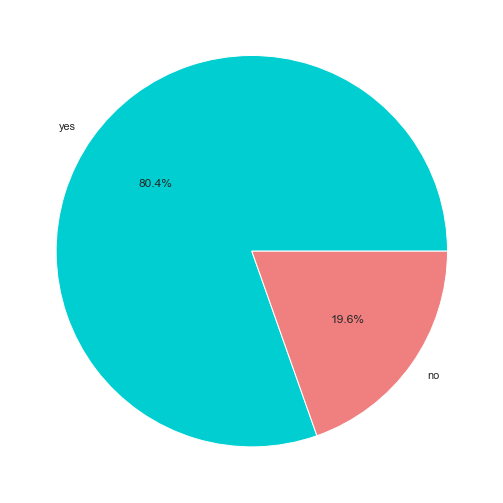

In [40]:
plt.figure(figsize = (20,9))
colors = ['darkturquoise','lightcoral','yellowgreen','deepskyblue']
plt.pie(x=df.physical_activity.value_counts(), 
        labels=df.physical_activity.value_counts().index,
        colors=colors,
        autopct='%1.1f%%');

About 90% of our dataset do not exercise.

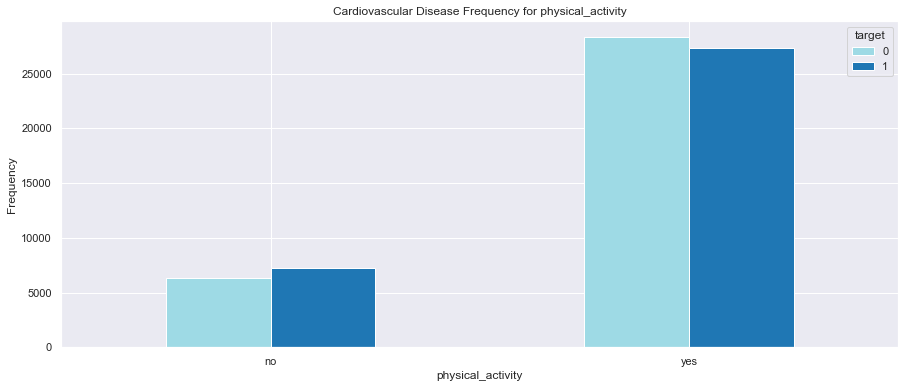

In [41]:
pd.crosstab(df.physical_activity,df.target).plot(kind="bar",colormap="tab20_r",figsize=(15,6))
plt.title('Cardiovascular Disease Frequency for physical_activity')
plt.xlabel('physical_activity')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

Physical exercises reduces the chance of cardiovascular disease.

## Numerical Features

In [42]:
num_features = [var for var in df.columns if df[var].dtypes!='O' and var not in 'target']
print(num_features)
df[num_features].head()

['age', 'height', 'weight', 'systolic_blood_pressure', 'diastolic_blood_pressure']


age  height  weight  systolic_blood_pressure  diastolic_blood_pressure
0  62.0     155    69.0                      130                        80
1  40.0     163    71.0                      110                        70
2  60.0     165    70.0                      120                        80
3  40.0     165    85.0                      120                        80
4  64.0     155    62.0                      120                        80

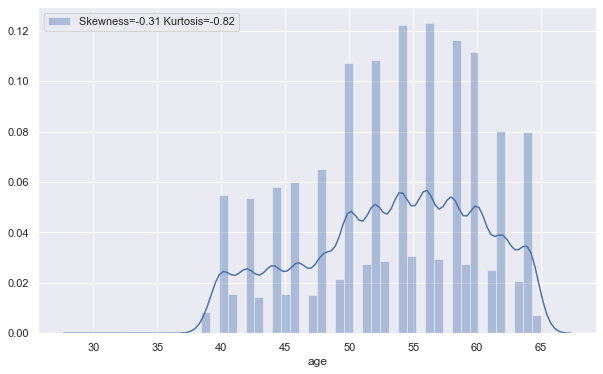

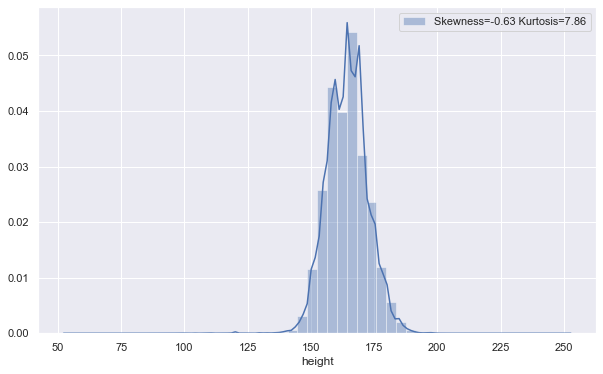

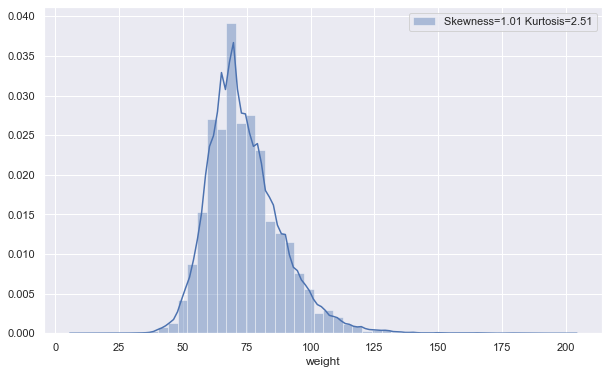

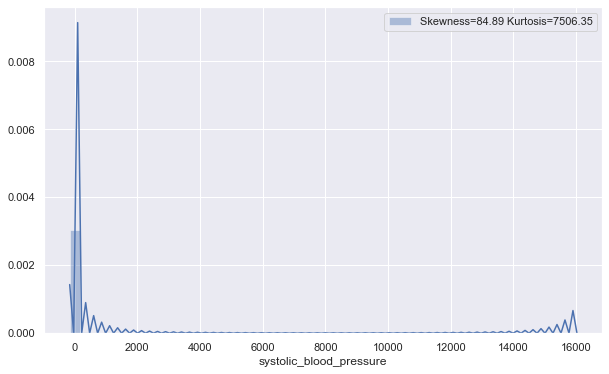

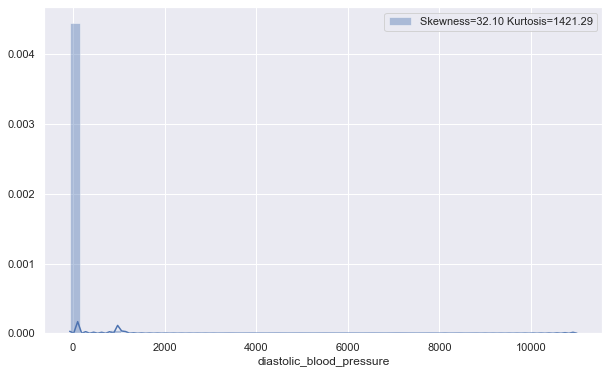

In [43]:
# Let's go ahead and analyse the distributions of these variables
def analyse_continuous(df, var):
    df = df.copy()  
    df = df.dropna(axis=0)
    plt.figure(figsize=(10,6))
    sns.set_style("darkgrid")
    sns.distplot(df[var], hist=True)
    plt.legend(['Skewness={:.2f} Kurtosis={:.2f}'.format(
            df[var].skew(), 
            df[var].kurt())
        ],
        loc='best')
    plt.show()

for var in num_features:
    analyse_continuous(df, var)

In [44]:
df.describe().T

count        mean  ...    75%      max
age                       69301.0   53.338177  ...   58.0     65.0
height                    69301.0  164.362217  ...  170.0    250.0
weight                    69301.0   74.203027  ...   82.0    200.0
systolic_blood_pressure   69301.0  128.829584  ...  140.0  16020.0
diastolic_blood_pressure  69301.0   96.650092  ...   90.0  11000.0
target                    69301.0    0.499589  ...    1.0      1.0

[6 rows x 8 columns]

## Log Transformation

In [45]:
systolic_var = np.var(df['systolic_blood_pressure'])
df['systolic_blood_pressure'] = df['systolic_blood_pressure'].apply(lambda x: (systolic_var + x)**2)

diastolic_var = np.var(df['diastolic_blood_pressure'])
df['diastolic_blood_pressure'] = df['diastolic_blood_pressure'].apply(lambda x: (systolic_var + x)**2)

In [46]:
df[num_features] = np.log1p(df[num_features])

In [47]:
df.describe().T

count       mean  ...        75%        max
age                       69301.0   3.987135  ...   4.077537   4.189655
height                    69301.0   5.106855  ...   5.141664   5.525453
weight                    69301.0   4.302905  ...   4.418841   5.303305
systolic_blood_pressure   69301.0  20.178578  ...  20.179536  21.192029
diastolic_blood_pressure  69301.0  20.175881  ...  20.175382  20.923645
target                    69301.0   0.499589  ...   1.000000   1.000000

[6 rows x 8 columns]

## Categorical Features

In [48]:
cat_features = [var for var in df.columns if var not in num_features+['target']]
print(cat_features)
df[cat_features].head()

['gender', 'cholesterol', 'glucose_level', 'smoking', 'alcohol_intake', 'physical_activity']


gender   cholesterol glucose_level smoking alcohol_intake physical_activity
0    male  above normal  above normal      no             no               yes
1    male        normal        normal      no             no               yes
2    male        normal        normal      no             no               yes
3  female        normal        normal     yes            yes               yes
4    male        normal        normal      no             no               yes

## Correlation

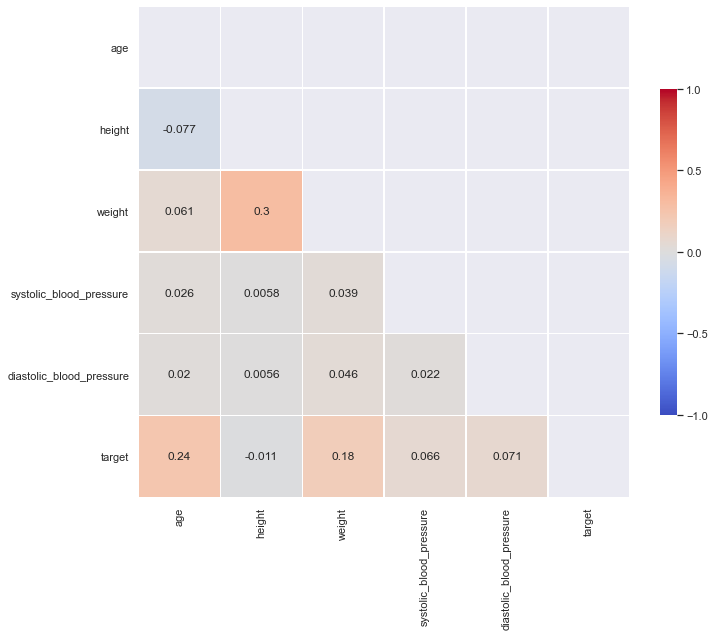

In [49]:
corr_matrix = df.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Categorical Encoding

In [50]:
df = pd.get_dummies(df, drop_first=True)

In [51]:
df.head()

age    height  ...  alcohol_intake_yes  physical_activity_yes
0  4.143135  5.049856  ...                   0                      1
1  3.713572  5.099866  ...                   0                      1
2  4.110874  5.111988  ...                   0                      1
3  3.713572  5.111988  ...                   1                      1
4  4.174387  5.049856  ...                   0                      1

[5 rows x 14 columns]

In [52]:
df.columns

Index(['age', 'height', 'weight', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'target', 'gender_male',
       'cholesterol_normal', 'cholesterol_well above normal',
       'glucose_level_normal', 'glucose_level_well above normal',
       'smoking_yes', 'alcohol_intake_yes', 'physical_activity_yes'],
      dtype='object')

## Train-Test Split

In [53]:
df.columns

Index(['age', 'height', 'weight', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'target', 'gender_male',
       'cholesterol_normal', 'cholesterol_well above normal',
       'glucose_level_normal', 'glucose_level_well above normal',
       'smoking_yes', 'alcohol_intake_yes', 'physical_activity_yes'],
      dtype='object')

***Spliting with data no scaling***

In [54]:
y = df['target']
X = df.drop(['target'],axis=1)

# Creating Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

***Spliting with data scaling***

In [55]:
sc = StandardScaler()
X2_train = sc.fit_transform(X_train)
X2_test = sc.fit_transform(X_test)
y2_train = y_train
y2_test = y_test

# Models

## Logistic Regression

In [56]:
lr = LogisticRegression(random_state=42)
score = cross_val_score(lr, X_train, y_train, scoring='roc_auc', n_jobs=-1)
score.mean()

0.697834822378808

In [57]:
score = cross_val_score(lr, X2_train, y2_train, scoring='roc_auc', n_jobs=-1)
score.mean()

0.7866811480734954

In [58]:
lr.fit(X2_train, y2_train)

LogisticRegression(random_state=42)

In [59]:
lr_predict_proba = lr.predict_proba(X2_test)
lr_predict = lr.predict(X2_test)

In [60]:
lr_predict_mine = np.where(lr_predict_proba > 0.35, 1, 0)

In [61]:
lr_predict_proba[10:20][:,1]

array([0.6334544 , 0.81947871, 0.19284279, 0.64795617, 0.75232936,
       0.43788071, 0.72409253, 0.45148125, 0.27290598, 0.79674551])

In [62]:
y2_test[10:20]

35305    1
64169    0
22328    0
8506     1
11607    1
28761    1
44778    1
45867    1
33211    0
10218    1
Name: target, dtype: int64

In [63]:
lr_predict_mine[10:20][:,1]

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [64]:
y2_test[10:20]

35305    1
64169    0
22328    0
8506     1
11607    1
28761    1
44778    1
45867    1
33211    0
10218    1
Name: target, dtype: int64

In [65]:
conf_matrix = confusion_matrix(y2_test, lr_predict)
conf_matrix

array([[6511, 2143],
       [2826, 5846]])

In [66]:
total=sum(sum(conf_matrix))

sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.6973331905322909
Specificity :  0.731756164726499


In [67]:
conf_matrix = confusion_matrix(y2_test, lr_predict_mine[:][:,1])
conf_matrix

array([[3404, 5250],
       [ 802, 7870]])

In [68]:
total=sum(sum(conf_matrix))

sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.809320019020447
Specificity :  0.5998475609756098


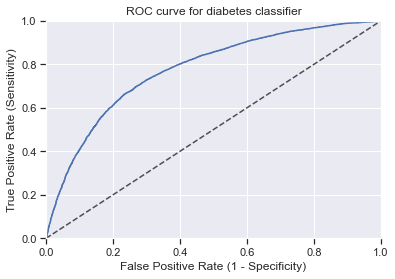

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, lr_predict_proba[:,1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [70]:
auc(fpr, tpr)

0.7760348287740156

## Naive Bayes

In [71]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [72]:
nb_predict = gnb.predict(X_test)

In [73]:
nb_predict[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
y_test[:10]

64958    1
36528    1
40271    0
65446    1
32000    1
49696    1
31675    0
30650    0
46564    0
66400    1
Name: target, dtype: int64

In [75]:
conf_matrix = confusion_matrix(y_test, nb_predict)
conf_matrix

array([[7586, 1068],
       [6181, 2491]])

In [76]:
total=sum(sum(conf_matrix))

sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.5510278201496331
Specificity :  0.6999157066591739


## SVMClassifier

In [77]:
svm_param_grid = {'C': [0.1, 10],
                 'gamma': [1, 0.01]}

svm_grid = GridSearchCV(estimator=SVC(), cv=3,
                        param_grid=svm_param_grid,
                        n_jobs=-1, verbose=10)

In [78]:
svm_grid.fit(X2_train, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  8.2min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 10.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 11.8min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 10], 'gamma': [1, 0.01]}, verbose=10)

In [79]:
svm_grid.best_params_

{'C': 10, 'gamma': 0.01}

In [80]:
svm_grid.best_estimator_

SVC(C=10, gamma=0.01)

In [81]:
svm_predict = svm_grid.predict(X2_test)

In [82]:
svm_predict[:10]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1])

In [83]:
y2_test[:10]

64958    1
36528    1
40271    0
65446    1
32000    1
49696    1
31675    0
30650    0
46564    0
66400    1
Name: target, dtype: int64

In [84]:
conf_matrix = confusion_matrix(y2_test, svm_predict)
conf_matrix

array([[6696, 1958],
       [2791, 5881]])

In [85]:
total=sum(sum(conf_matrix))

sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.7058079477179298
Specificity :  0.7502232427605562


## KNN

In [86]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=1)

In [87]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=1, n_neighbors=3)

In [88]:
knn_predict_proba = knn.predict_proba(X_test)
knn_predict = knn.predict(X_test)

In [89]:
knn_predict_proba[:10][:,1]

array([0.33333333, 0.66666667, 0.        , 0.66666667, 0.        ,
       0.        , 1.        , 0.33333333, 0.33333333, 0.66666667])

In [90]:
y_test[:10]

64958    1
36528    1
40271    0
65446    1
32000    1
49696    1
31675    0
30650    0
46564    0
66400    1
Name: target, dtype: int64

In [91]:
conf_matrix = confusion_matrix(y_test, knn_predict)
conf_matrix

array([[5229, 3425],
       [3539, 5133]])

In [92]:
total=sum(sum(conf_matrix))

sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.5963731751824818
Specificity :  0.5997896704837579


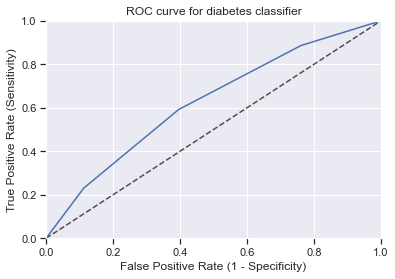

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, knn_predict_proba[:,1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [94]:
auc(fpr, tpr)

0.6248162496791365

## RandomForestClassifier

In [95]:
from sklearn.model_selection import RandomizedSearchCV

In [96]:
n_estimators = [int(x) for x in np.linspace(100,1200,12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5,10,6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [97]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features, 
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf}

In [98]:
rf_grid = RandomizedSearchCV(RandomForestClassifier(), random_grid, scoring='roc_auc', n_jobs=-1)

rf_grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 6, 7, 8, 9, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='roc_auc')

In [99]:
rf_grid_predict = rf_grid.predict(X_test)
rf_grid_pred_proba = rf_grid.predict_proba(X_test)[:, 1]

In [100]:
rf_grid_pred_proba[10:30]

array([0.81395595, 0.78798909, 0.12187882, 0.69091142, 0.82743437,
       0.35776608, 0.84338046, 0.38266362, 0.28425487, 0.80522463,
       0.21701521, 0.51677876, 0.81778514, 0.81645592, 0.64216004,
       0.21199863, 0.58238255, 0.19677561, 0.27036823, 0.729112  ])

In [101]:
y_test[10:30]

35305    1
64169    0
22328    0
8506     1
11607    1
28761    1
44778    1
45867    1
33211    0
10218    1
52542    0
14733    0
11639    1
66578    1
40381    0
60488    0
57004    1
31037    0
7786     1
10746    1
Name: target, dtype: int64

In [102]:
conf_matrix = confusion_matrix(y_test, rf_grid_predict)
conf_matrix

array([[6890, 1764],
       [2825, 5847]])

In [103]:
total=sum(sum(conf_matrix))

sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.7092125579001544
Specificity :  0.7682301931415058


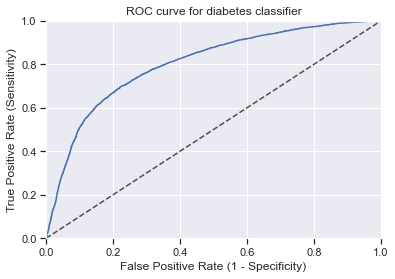

In [104]:
fpr, tpr, thresholds = roc_curve(y_test, rf_grid_pred_proba)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [105]:
auc(fpr, tpr)

0.8024076435443115

***Custom Threshold***

In [106]:
rf_pred_mine = np.where(rf_grid_pred_proba > 0.35, 1, 0)

In [107]:
rf_pred_mine[10:30]

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [108]:
y_test[10:30]

35305    1
64169    0
22328    0
8506     1
11607    1
28761    1
44778    1
45867    1
33211    0
10218    1
52542    0
14733    0
11639    1
66578    1
40381    0
60488    0
57004    1
31037    0
7786     1
10746    1
Name: target, dtype: int64

In [109]:
conf_matrix = confusion_matrix(y_test, rf_pred_mine)
conf_matrix

array([[4860, 3794],
       [1324, 7348]])

In [110]:
total=sum(sum(conf_matrix))

sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.7858990944372575
Specificity :  0.6594866271764495


In [111]:
rf_grid.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=1100)

In [112]:
rf_grid.best_params_

{'n_estimators': 1100,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 10}

## Model Stacking

We got best results from Logistic Regression, Support Vector Machine, and Random Forest Classifier. We will be stacking these models to get a better result. We will be using SVM and Random Forest as our base model and Logistic Regression as our Meta Model.

In [113]:

from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [114]:
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression(random_state=42)))
level0.append(('svm', SVC(C=10, gamma=0.01, probability=True, random_state=42)))
level0.append(('rf', RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                   n_estimators=1000, random_state=42)))

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, n_jobs=1)

model.fit(X2_train, y2_train)

pred_proba = model.predict_proba(X2_test)

In [115]:
pred_proba[10:30][:,1]

array([0.68903883, 0.81160132, 0.14328779, 0.7429668 , 0.74561632,
       0.34286168, 0.73444453, 0.37053823, 0.24599753, 0.80263884,
       0.20060723, 0.33555514, 0.71260804, 0.82688438, 0.56270182,
       0.19711354, 0.44933929, 0.19554849, 0.26368784, 0.72241845])

In [116]:
y2_test[10:30]

35305    1
64169    0
22328    0
8506     1
11607    1
28761    1
44778    1
45867    1
33211    0
10218    1
52542    0
14733    0
11639    1
66578    1
40381    0
60488    0
57004    1
31037    0
7786     1
10746    1
Name: target, dtype: int64

In [117]:
prediction = np.where(pred_proba[:][:,1] > 0.25, 1, 0)

In [118]:
conf_matrix = confusion_matrix(y2_test, prediction)
conf_matrix

array([[3369, 5285],
       [ 692, 7980]])

In [119]:
total=sum(sum(conf_matrix))

sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8295986210293032
Specificity :  0.6015831134564644


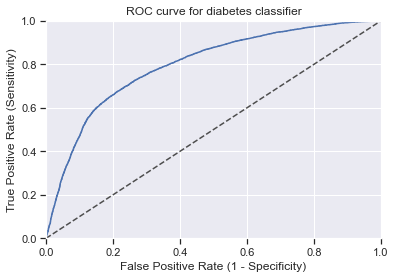

In [120]:
fpr, tpr, thresholds = roc_curve(y2_test, pred_proba[:][:,1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [121]:
auc(fpr, tpr)

0.7977793740411405

In [122]:
data = pd.DataFrame()

In [123]:
data['oi'] = '1'
data['ki'] = '1'

In [124]:
data.head()

Empty DataFrame
Columns: [oi, ki]
Index: []